In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

data = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### Exploratory Data Analysis

There are four types of smoking statuses: Unknown, formerly smoked, never smoked, and smokes.

In [53]:
data.groupby('smoking_status').size()

smoking_status
Unknown            1544
formerly smoked     885
never smoked       1892
smokes              789
dtype: int64

Also, there are five types of work: goverment job, never worked, private, self-employed, and children. Along with two types of residences: rural and urban.

In [54]:
data.groupby('work_type').size()

work_type
Govt_job          657
Never_worked       22
Private          2925
Self-employed     819
children          687
dtype: int64

In [55]:
data.groupby('Residence_type').size()

Residence_type
Rural    2514
Urban    2596
dtype: int64

We can check for any null values in our data.

In [56]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Let's make a scatterplot to visualize the relationship between age and average glucose level.

<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>

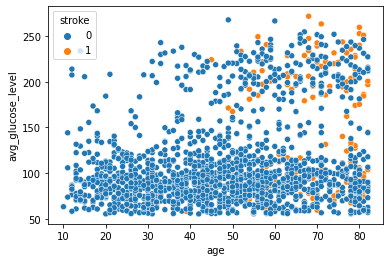

In [4]:
sns.scatterplot(data=data.head(1700), x='age', y='avg_glucose_level', hue='stroke')

Notice that people who had strokes were of ages between 40 to 80 with an average glucose level ranging from 100 to 250.

Even though we only used 1,700 data points, our scatterplot is very cluttered. We will use a contour plot for a clearer view of the data in its entirety.

<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>

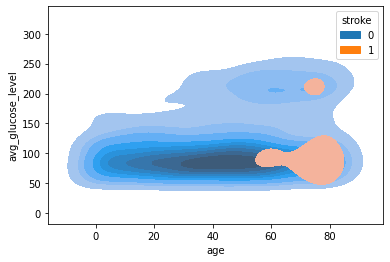

In [58]:
sns.kdeplot(
    data=data, x='age', y='avg_glucose_level', hue='stroke', fill=True
)

We see that age can be a factor of having a stroke from the visualization above.

<AxesSubplot:xlabel='age', ylabel='bmi'>

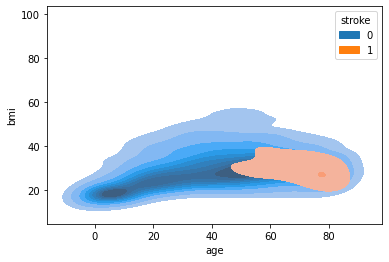

In [60]:
sns.kdeplot(
    data=data, x='age', y='bmi', hue='stroke', fill=True
)

<AxesSubplot:xlabel='smoking_status', ylabel='age'>

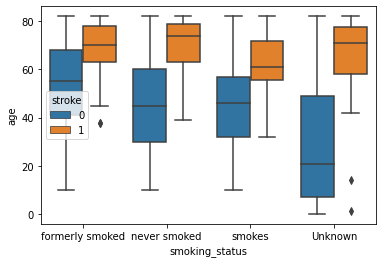

In [61]:
sns.boxplot(x='smoking_status', y='age', hue='stroke', data=data)

<AxesSubplot:xlabel='smoking_status', ylabel='avg_glucose_level'>

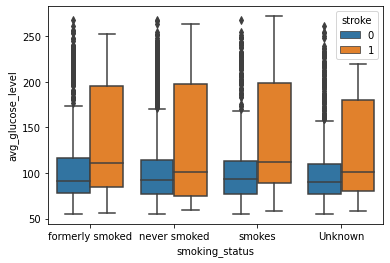

In [62]:
sns.boxplot(x='smoking_status', y='avg_glucose_level', hue='stroke', data=data)

We see that age and average glucose level are most likely good predictors for a stroke.

Let's take a look at the relationship between average glucose level and BMI. Based on this study (https://www.ijcmr.com/uploads/7/7/4/6/77464738/ijcmr_1592.pdf), there should be a positive correlation to high BMI and high glucose levels. First, we sample the data to avoid overplotting, then we filter out BMI values that are null.

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

<AxesSubplot:xlabel='bmi', ylabel='avg_glucose_level'>

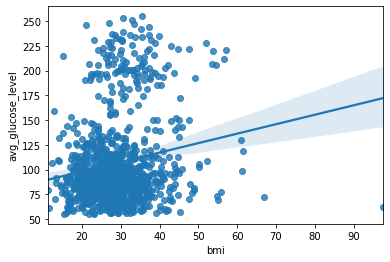

In [90]:
data_sample = data.sample(1000)
data_sample = data_sample[data_sample['bmi'].isnull() == False]
display(data_sample.isnull().sum())

sns.regplot(data=data_sample, x='bmi', y='avg_glucose_level')

We see that there is indeed a slight correlation with average glucose level and BMI.

Because of this, and the fact that BMI has null values, we will not choose BMI as one of our features for the logistic regression model.

Relevant features for our model are: gender, age, hypertension, heart disease, average glucose levels, marital history, work type, residence type, and smoking status.

### Data Cleaning and Processing

The ETL pipeline will clean and format all the appropriate data, then, in order to train our logistic regression model, we will transform our categorical data into numerical values using StringIndexer, OneHotEncoder, and VectorAssembler.

In [69]:
import sys
sys.path.insert(0, '../jobs')

In [70]:
import etl_job as etl

In [71]:
df = etl.start()

+----+------------+-------------+-----------------+------+------------+-------------+--------------+---------------+
| age|hypertension|heart_disease|avg_glucose_level|gender|ever_married|    work_type|Residence_type| smoking_status|
+----+------------+-------------+-----------------+------+------------+-------------+--------------+---------------+
|67.0|         0.0|          1.0|           228.69|  male|         yes|      private|         urban|formerly smoked|
|61.0|         0.0|          0.0|           202.21|female|         yes|self-employed|         rural|   never smoked|
|80.0|         0.0|          1.0|           105.92|  male|         yes|      private|         rural|   never smoked|
|49.0|         0.0|          0.0|           171.23|female|         yes|      private|         urban|         smokes|
|79.0|         1.0|          0.0|           174.12|female|         yes|self-employed|         rural|   never smoked|
|81.0|         0.0|          0.0|           186.21|  male|      

Now that we have a pandas DataFrame returned from our pipeline, the DataFrame is ready for training.

### Building the Logistic Regression Model

We will use a logistic regression model to predict if people had a stroke in our dataset with a 90-10 split of our data into training and test sets.

In [95]:
model = LogisticRegression(max_iter=5000)

df['stroke'] = data['stroke']

train, test = train_test_split(df, test_size=0.10, random_state=42)

X_train, y_train = train.iloc[:,:len(df.columns)-1], train['stroke']
X_test, y_test = test.iloc[:,:len(df.columns)-1], test['stroke']

In [97]:
model.fit(X_train, y_train)
predictions = model.predict(X_train)
print('Training Accuracy: ', model.score(X_train, y_train))
print('Test Accuracy: ', model.score(X_test, y_test))

Training Accuracy:  0.9521635138073494
Test Accuracy:  0.9452054794520548


#### Our final model's training accuracy is 95.22% and test accuracy is 94.52%.